In [1]:
from keras.datasets import mnist

import numpy as np

import module
import optimizer 
import loss 
import datahandler


from matplotlib import pyplot as plt
import numpy as np
from numpy import shape

from tqdm import tqdm


2024-12-14 13:08:33.682667: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-14 13:08:34.423709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-14 13:08:34.423857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-14 13:08:34.576535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 13:08:34.861917: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-14 13:08:34.866617: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:

def prepocess_data(x_train, y_train, x_test, y_test, training_size, test_size):
    x_train = x_train.reshape(x_train.shape[0], 28 * 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28 * 28, 1)

    x_train = x_train.T
    x_test = x_test.T

    x_train = x_train[:, :, 0:training_size]
    x_test = x_test[:, :, 0:test_size]

    x_train = x_train[0, :, 0:training_size]
    x_test = x_test[0, :, 0:test_size]

    #  y = np_utils.to_categorical(y)
    # y = y.reshape(y.shape[0], 10, 1)
    



    y_test = y_test[:test_size]
    y_train = y_train[:training_size]
   
    # a = np.linspace(0, 10, 1)
    # A = np.outer(np.ones(training_size), a)
    # Y_train = np.outer(y_train, np.ones(10))
    # equindeces = (Y_train == A).astype(int)
    # Y_train = A.T @ equindeces
    
    
    y_tr = np.zeros((10, training_size))
    y_ts = np.zeros((10, test_size))
    
    y_tr[0, :] = y_train
    y_ts[0, :] = y_test

    y_test = y_ts
    y_train = y_tr
    for i in range(training_size):
        n_tmp = int(y_train[0, i])

        
        y_train[:, i] = np.zeros(10)
        y_train[n_tmp, i] = 1
    print(y_train)

    for i in range(test_size):
        n_tmp = int(y_test[0, i])

        y_test[:, i] = np.zeros(10)
        y_test[n_tmp, i] = 1
    # print(y_test)


    x_test, y_test = reshuffle(x_test, y_test)
    x_train, y_train = reshuffle(x_train, y_train)

    return (x_train, y_train, x_test, y_test)


def reshuffle(X, Y):
    NData = len(X[0, :])
    perm_indices = np.arange(NData)
    np.random.shuffle(perm_indices)
    X = X[:, perm_indices]
    Y = Y[:, perm_indices]
    return X, Y

def flatten_input(x):
    x = x.reshape(x.shape[0], 28 * 28, 1)
    """
    TODO figure this out
    """

    x = x.astype("float32") / 255
    return x



In [3]:

# load MNIST using Keras
# Select 1000 training samples and 20 test samples and appropriate preprocess them
training_size = 2000
test_size = 100
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# x_train = flatten_input(x_train)
# x_test = flatten_input(x_test)

# x_train = prepocess_data(x_train, y_train, training_size)
# x_test = prepocess_data(x_test, y_test, test_size)


inDimension = 28*28

(x_train, y_train, x_test, y_test) = prepocess_data(x_train, y_train, x_test, y_test, training_size, test_size)

print(np.shape(x_test))
print(np.shape(x_train))
print(np.shape(y_test))
print(np.shape(y_train))


[[0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(784, 100)
(784, 2000)
(10, 100)
(10, 2000)


In [4]:
from loss import LossFunction

class GenLoss(LossFunction):

    def __init__(self):
        self.gradOut = None
        self.valOut = None 

    def __call__(self, x, y):
        assert self.valOut is not None, 'Error: Value is not initialized'
        return self.valOut

    def gradient(self, x, y):
        assert self.gradOut is not None, 'Error: Gradient is not initialized'
        return self.gradOut
        

In [5]:
import random

def randomMerge(A, B, shuffle = True):
    '''
    given two matrices A and B, merge them and shuffle the new matrix entries

    returns 
    C              :                                       merged array
    indices        :          merged indices describing the permutation
    idx_map        :  at index i contains the position that i is stored
    '''
    assert len(A) == len(B), 'A and B must be of same length at dimension 0'
    len_a = len(A[0])
    len_b = len(B[0])
    numData = len_a + len_b
    C = np.zeros((len(A), numData))
    for i in range(len(A[0])):
        C[:, i] = A[:, i]
    for i in range(len_a, numData):
        C[:, i] = B[:, i-len_a]

    indices = list(range(numData))
    if not shuffle:
        return C, indices, indices

    random.shuffle(indices)
    C = [C[:, idx] for idx in indices]
    C = np.column_stack(C)
    
    idx_map = [None]*len(indices)
    for i, idx in enumerate(indices):
        idx_map[idx] = i

    return C, indices, idx_maps

A = np.ones((2, 10))
B = np.zeros((2, 11))
C, ids, idx_map = randomMerge(A, B)
print(f' A = {A}\nB={B}\nC=\n{C}\nindices={ids}\nmap = {idx_map}')

 A = [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
B=[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
C=
[[1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]]
indices=[8, 4, 11, 1, 7, 5, 13, 6, 20, 16, 17, 15, 3, 10, 0, 12, 9, 14, 2, 18, 19]
map = [14, 3, 18, 12, 1, 5, 7, 4, 0, 16, 13, 2, 15, 6, 17, 11, 9, 10, 19, 20, 8]


In [6]:

import module
import optimizer 
import loss 
import datahandler


#
#  generator ====================================================================
generator = module.Module()
generator.appendLayer(inDimension)

for i in range(3):
    generator.appendLayer(1000)

generator.appendLayer(inDimension)

generator.printShape()

# nn.setLossFunction(loss.L2Loss)
generator.setLossFunction(GenLoss)


# opt = optimizer.SGD(nn, learning_rate=0.1, dynamic_step=True)
gen_opt = optimizer.SGD(generator, learning_rate=0.1, dynamic_step=True, weight_normalization=True)

# dicriminator =================================================================

discriminator = module.Module()
discriminator.appendLayer(inDimension)

for i in range(2):
    discriminator.appendLayer(100)

discriminator.appendLayer(2, activation='softmax')
discriminator.printShape()
discriminator.setLossFunction(loss.CrossEntropyLoss)


dis_opt = optimizer.SGD(discriminator, learning_rate=0.1, dynamic_step=True, weight_normalization=True)


# opt = optimizer.SGD(nn, learning_rate=0.1)

loss_vector_sgd_gen = []
loss_vector_sgd_dis = []

wnorm_sgd = []

# N = 100
batch_size = 50
dataHandler = datahandler.DataHandler(x_train, y_train, batch_size=batch_size)


get_noise = lambda mu, sigma, dimension, N : np.random.randn(dimension, N)*sigma + mu


# no_epochs = 10
no_epochs = 30
for j in tqdm(range(no_epochs), desc=f"Processing:"):
    
    dataHandler.reset()
    epoch_loss_gen = []
    epoch_loss_dis = []
    while dataHandler.hasNext():
        
        ################# take next batch from train set
        
        (batchX, batchY) = dataHandler.nextBatch()
        
        # almost always equal to the real batch_size, except for the last batch
        batchSizeTrue = len(batchX[0]) 
        batchY = np.zeros((2, batchSizeTrue))
        for i in range(batchSizeTrue):
            batchY[1,i] = 1
        # print(np.shape(batchY))

        batchY_fake = np.zeros((2, batchSizeTrue))
        for i in range(batchSizeTrue):
            batchY_fake[0, i] = 1
        
        """
        pass the batch of noise along with the label 1 into the generator
        """
        generator(get_noise(0, 1, inDimension, batchSizeTrue), batchY_fake)

        generator.forward()

        # take the generator's output and shuffle it with the actual ones
        batchX_fake = generator.output
        mixedBatchX, mixed_idcs, idx_map = randomMerge(batchX, batchX_fake, shuffle = True)
        mixedBatchX = np.array(mixedBatchX)
        # print(f'mixed batch X {np.shape(mixedBatchX)}')

        # having kept the permutation indices, merge the labels accordingly
        mixedBatchY, _, _ = randomMerge(batchY, batchY_fake, shuffle = False)
        mixedBatchY = np.array([mixedBatchY[:, idx] for idx in mixed_idcs]).T
        # print(f'mixed batch Y {np.shape(mixedBatchY)}')

        # time to pass the augmented batch into the discriminator
        discriminator(mixedBatchX, mixedBatchY)
        discriminator.forward()

        # print(f'output of discriminator {np.shape(discriminator.output)}')
        # pray for the best
        discriminator.calc_loss()
        discriminator.backward()
        dis_opt.step()

        ########################### backpropagate generator but only wrt to their respective output
        discr_output_fake = np.array([discriminator.output[:, idx_map[ii]] for ii in range(batchSizeTrue)])
        discr_loss_fake = np.array([discriminator.loss_function(discriminator.output[:, jj], discriminator.yhat[:, jj]) for jj in range(batchSizeTrue)])
        # assuming that number of real data = number of fake data
        discr_loss_real = np.array([discriminator.loss_function(discriminator.output[:, jj], discriminator.yhat[:, jj]) for jj in range(batchSizeTrue, 2*batchSizeTrue, 1)])
        
        # discr_loss_fake = np.array([discriminator.loss[idx_map[i]] for i in range(batchSizeTrue)])
        
        # print(f'shape of W^0 {np.shape(discriminator.propagated_gradients[0])}')
        discr_grads_fake = np.array([discriminator.propagated_gradients[0][ :, idx_map[i]] for i in range(batchSizeTrue)])

        
        generator.loss_instance.valOut = -discr_loss_fake.T - discr_loss_real.T
        generator.loss_instance.gradOut = -discr_grads_fake.T
        
        # print(f'gen loss {np.shape(generator.loss_instance.valOut)}')

        generator.backward()
        gen_opt.step()

        

        epoch_loss_gen.append(np.average(generator.loss))
        epoch_loss_dis.append(np.average(discriminator.loss))
        
    # print(f'epoch loss {np.shape(np.array(epoch_loss_gen))}')
    # print(f'and the avg is {np.shape(np.average(np.array(epoch_loss_gen)))}')
    loss_vector_sgd_gen.append(np.average(epoch_loss_gen))
    loss_vector_sgd_dis.append(np.average(epoch_loss_dis))

Number of Layers: 5
Total Parameters: 3571784 (3568000 weights and 3784 biases)
Size on RAM (approximate) 27904.56 kb
(784 None) x (1000 relu) x (1000 relu) x (1000 relu) x (784 relu)
Weight dimensions: (1000, 784), (1000, 1000), (1000, 1000), (784, 1000)
Number of Layers: 4
Total Parameters: 88802 (88600 weights and 202 biases)
Size on RAM (approximate) 693.77 kb
(784 None) x (100 relu) x (100 relu) x (2 softmax)
Weight dimensions: (100, 784), (100, 100), (2, 100)


Processing:: 100%|██████████| 30/30 [2:57:04<00:00, 354.17s/it]  


## print training plots

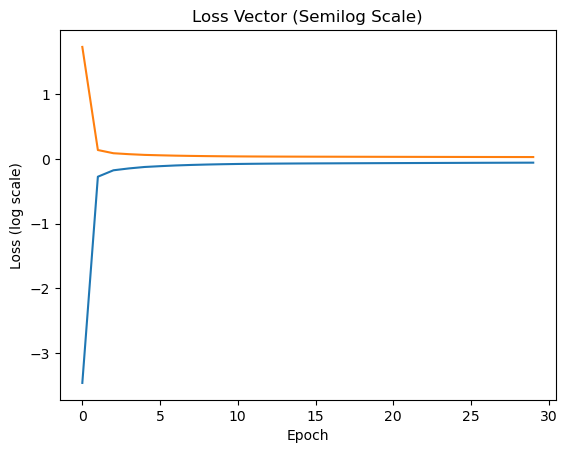

In [16]:

from matplotlib import pyplot as plt

plt.plot(loss_vector_sgd_gen, '-')
plt.plot(loss_vector_sgd_dis, '-')
plt.title('Loss Vector (Semilog Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.show()

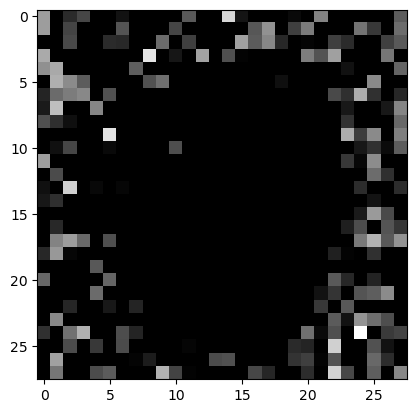

In [8]:
first_image = np.array(generator.output[:,0], dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

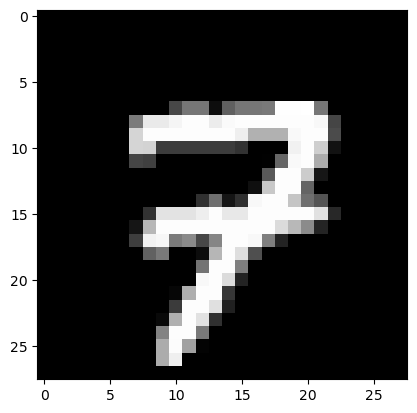

In [14]:
first_image = np.array(x_train[:, 0], dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')